##           MOVIE     RECOMMENDATION        ( CONTENT BASED )

# Plot description based Recommender
#### We will compute pairwise similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score. The plot description is given in the overview feature of our dataset. Let's take a look at the data. ..

### dataset - https://www.kaggle.com/tmdb/tmdb-movie-metadata

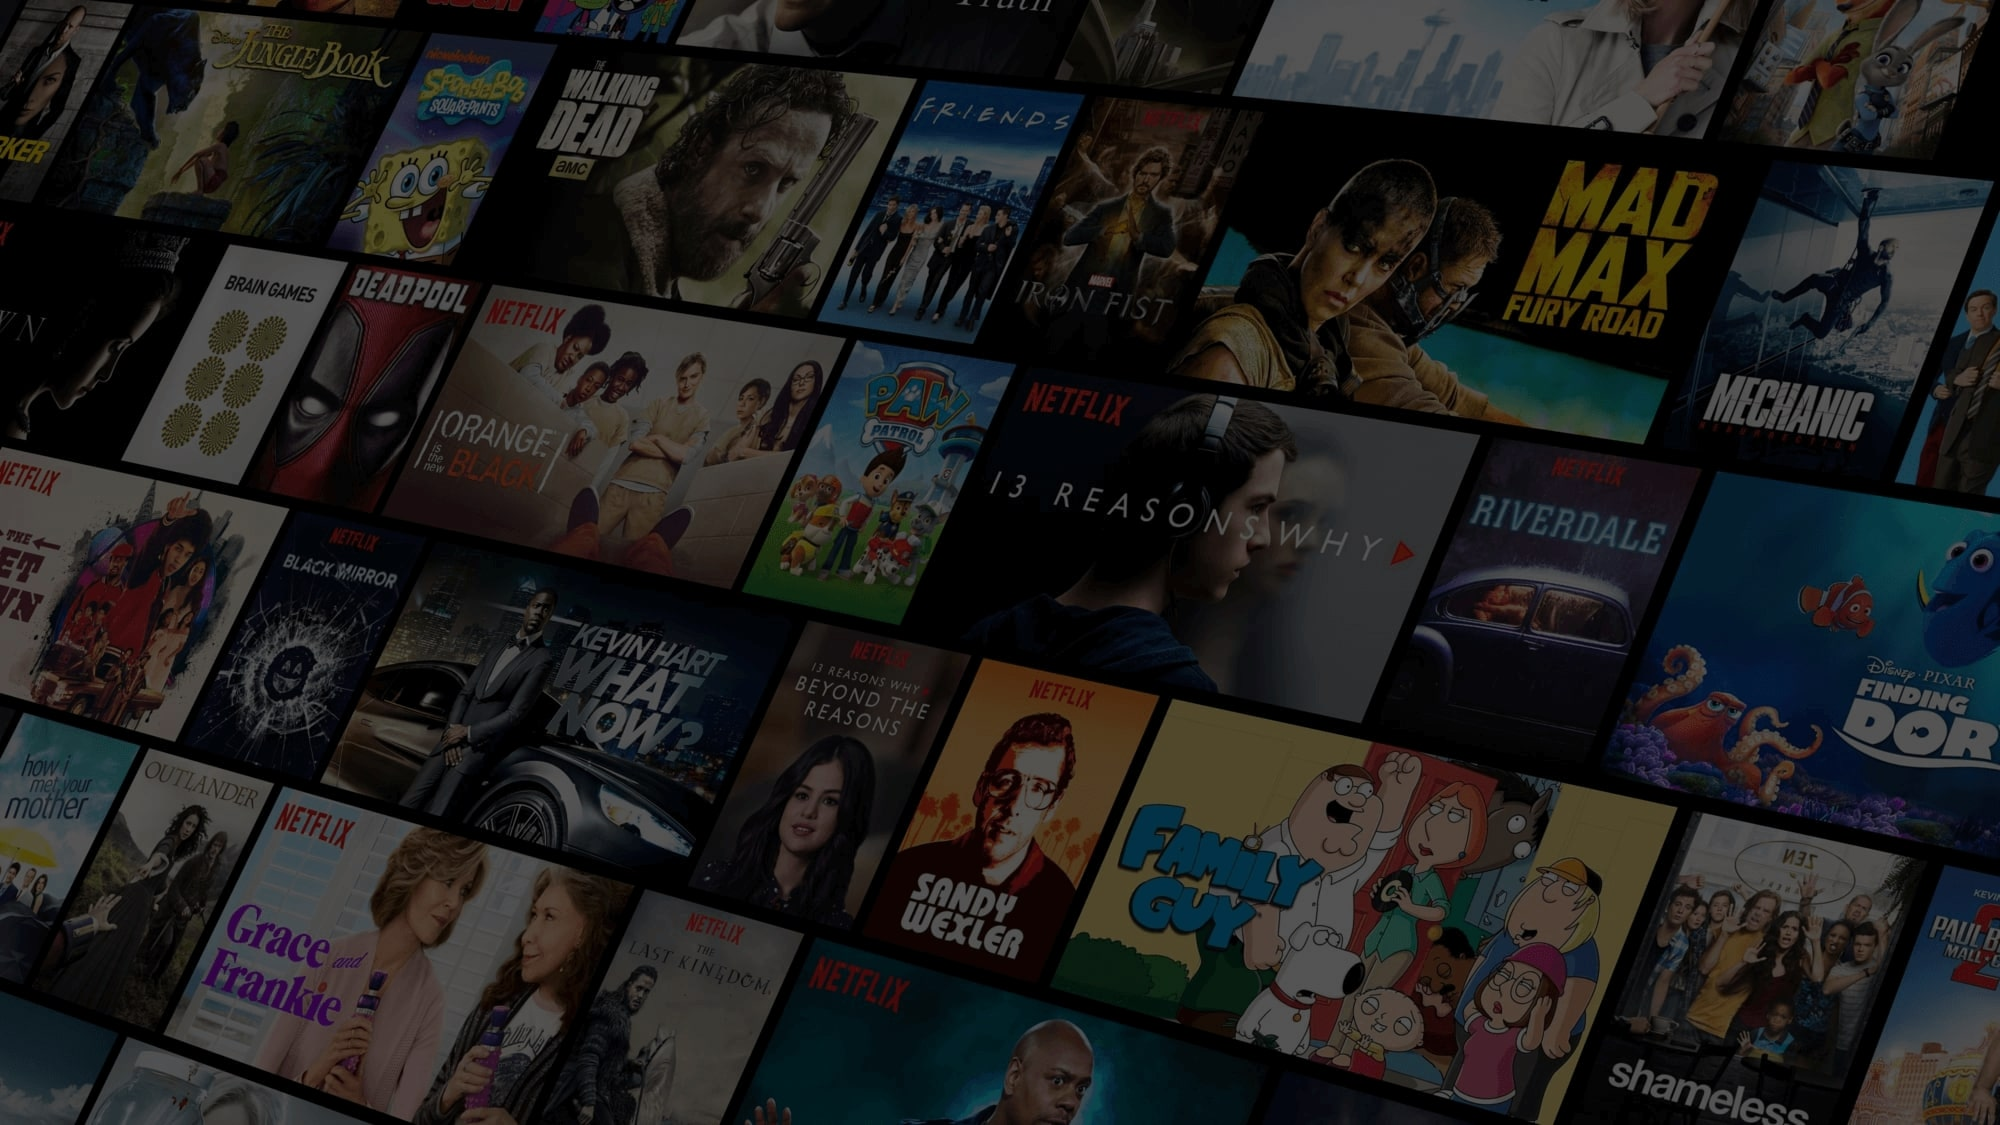

In [205]:
# importing necessary libraries
import pandas as pd
import numpy as np
import json
from collections import defaultdict,Counter,OrderedDict
import matplotlib.pyplot as plt
import squarify
from itertools import islice

In [206]:
# importing the data
credits = pd.read_csv("tmdb_5000_credits.csv")
movies = pd.read_csv("tmdb_5000_movies.csv")

In [207]:
# printing first 5 rows of movies dataframe
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [208]:
# printing first 5 rows of credits dataframe
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [209]:
# merging credits and movies dataframe together
df_merged = movies.merge(credits, left_on='id', right_on='movie_id')

In [210]:
# print first 5 rows of resulting merged dataframe
df_merged.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title_x,vote_average,vote_count,movie_id,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [211]:
df_merged.shape #shape of the merged dataframe

(4803, 24)

In [212]:
# transform all columns which had json string into json format
# several columns has id and name
# leave only name for them beacause id is not so important in this case
json_columns = {'cast', 'crew', 'genres', 'keywords', 'production_countries', 
                'production_companies', 'spoken_languages'}

for c in json_columns:
    df_merged[c] = df_merged[c].apply(json.loads)
    if c != "crew": # We need other information besides the name
        df_merged[c] = df_merged[c].apply(lambda row: [x["name"] for x in row])

In [213]:
# print first 5 rows after the transformation from dictonary to list
df_merged.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title_x,vote_average,vote_count,movie_id,title_y,cast,crew
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",...,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[{'credit_id': '52fe48009251416c750aca23', 'de..."
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",...,[English],Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[{'credit_id': '52fe4232c3a36847f800b579', 'de..."
2,245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[Columbia Pictures, Danjaq, B24]",...,"[Français, English, Español, Italiano, Deutsch]",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[{'credit_id': '54805967c3a36829b5002c41', 'de..."
3,250000000,"[Action, Crime, Drama, Thriller]",http://www.thedarkknightrises.com/,49026,"[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[Legendary Pictures, Warner Bros., DC Entertai...",...,[English],Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,The Dark Knight Rises,"[Christian Bale, Michael Caine, Gary Oldman, A...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de..."
4,260000000,"[Action, Adventure, Science Fiction]",http://movies.disney.com/john-carter,49529,"[based on novel, mars, medallion, space travel...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,[Walt Disney Pictures],...,[English],Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,John Carter,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de..."


In [214]:
#types of columns in merged dataframe
df_merged.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'movie_id', 'title_y', 'cast', 'crew'],
      dtype='object')

### Movies released by countries.

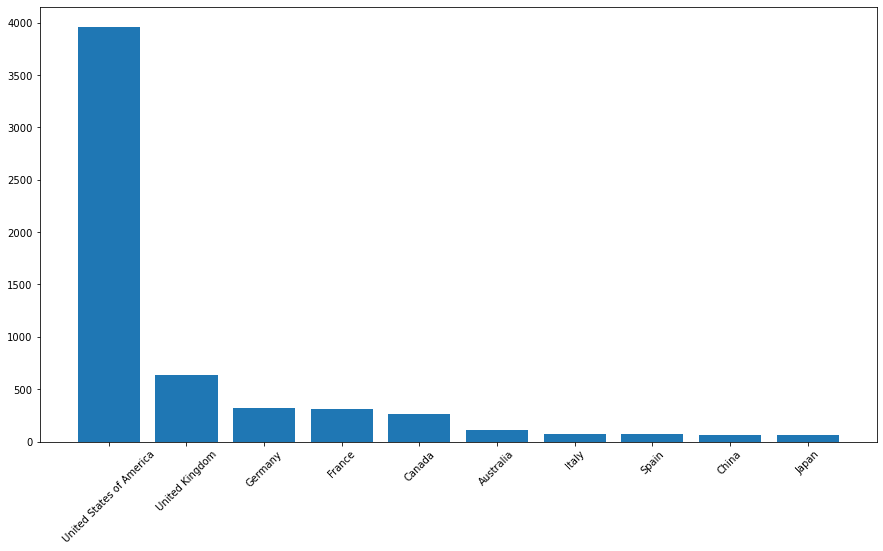

In [215]:
# creating the function to flatten list of list
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

# initiating a list
countries_list = []
for i in (df_merged['production_countries']):
     countries_list.append(i)
# applying the flatten finction and appending data in to the list
countries_list = flatten_list(countries_list)

# creating an ordered dictonary of the frequency counts entries in the list
b = Counter(countries_list)

# extracting the top 10 frequently occouring in the list
b  = OrderedDict(b.most_common(10))

# plotting the data
plt.figure(figsize=(15,8))
plt.bar(b.keys(), b.values())
plt.xticks(rotation = 45) 
plt.show()

### Movies according to the genre

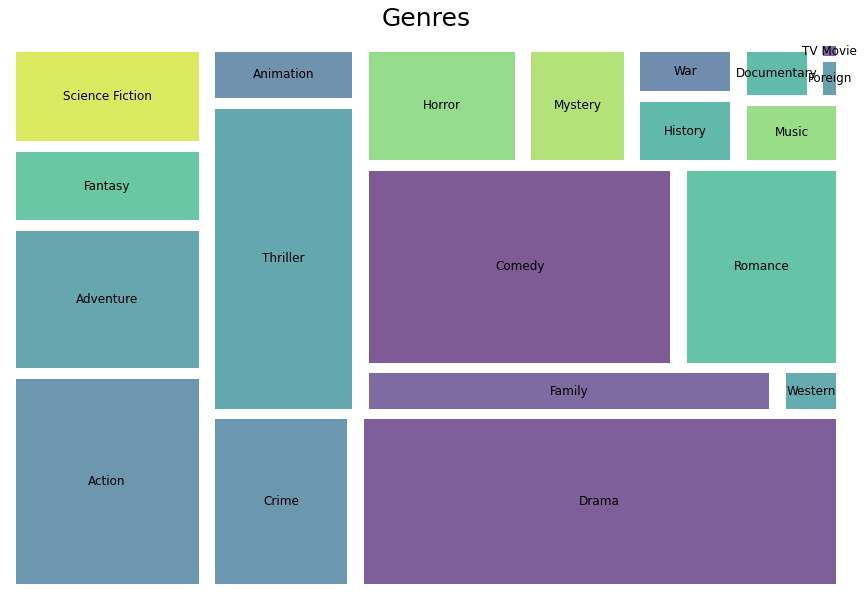

In [216]:
genres_flatten = sum(df_merged["genres"].values, []) # genres are list of lists
genres_info = Counter(genres_flatten)

plt.figure(figsize=(15, 10))
plt.title("Genres", fontsize=25, pad=20)
squarify.plot(genres_info.values(), label=genres_info.keys(), text_kwargs={'fontsize':12}, bar_kwargs={'alpha':.7}, pad=True)
plt.axis("off");

In [217]:
# taking the releveant columns
df = df_merged[['id','original_title','overview']].set_index('id')

In [218]:
df

,original_title,overview
id,,
19995,Avatar,"In the 22nd century, a paraplegic Marine is di..."
285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha..."
206647,Spectre,A cryptic message from Bond’s past sends him o...
49026,The Dark Knight Rises,Following the death of District Attorney Harve...
49529,John Carter,"John Carter is a war-weary, former military ca..."
...,...,...
9367,El Mariachi,El Mariachi just wants to play his guitar and ...
72766,Newlyweds,A newlywed couple's honeymoon is upended by th...
231617,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic..."


In [219]:
# dropping null values if any
df.dropna(inplace = True)

In [220]:
df.head(1)['overview']

id
19995    In the 22nd century, a paraplegic Marine is di...
Name: overview, dtype: object

### TFIDF
###### term frequency , it is the relative frequency of a word in a document and is given as (term instances/total instances). Inverse Document Frequency is the relative count of documents containing the term is given as log(number of documents/documents with term) The overall importance of each word to the documents in which they appear is equal to TF * IDF

###### This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each row represents a movie, as before.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

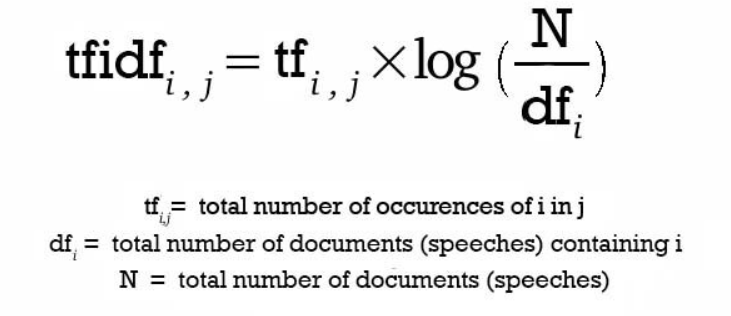

In [221]:
# importing TFIDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# initiating TFIDF vectorizer 
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',# word tokenize
                      token_pattern=r'\w{1,}',
            ngram_range=(1, 5),
            stop_words = 'english')



In [222]:
# Fitting the TF-IDF on the 'overview' text
tfv_matrix = tfv.fit_transform(df['overview'])

In [223]:
tfv_matrix.shape

(4800, 10430)

### Sigmoid kernel
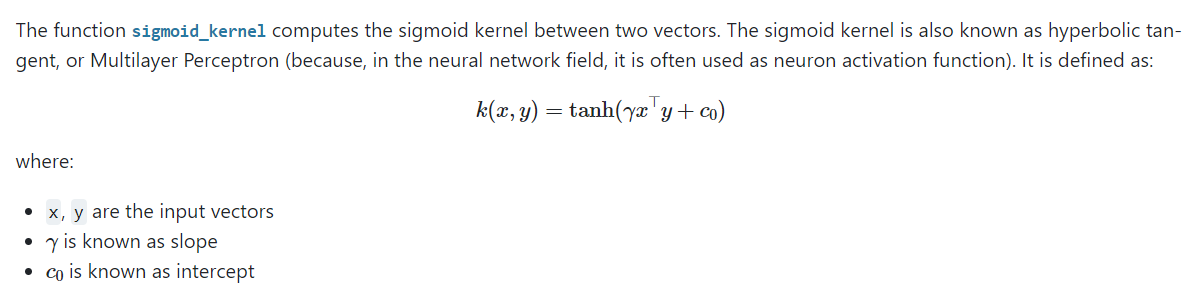

In [224]:
from sklearn.metrics.pairwise import sigmoid_kernel

# Compute the sigmoid kernel
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

##### Cosine similarity is the cosine of the angle between two n-dimensional vectors in an n-dimensional space. It is the dot product of the two vectors divided by the product of the two vectors' lengths (or magnitudes).
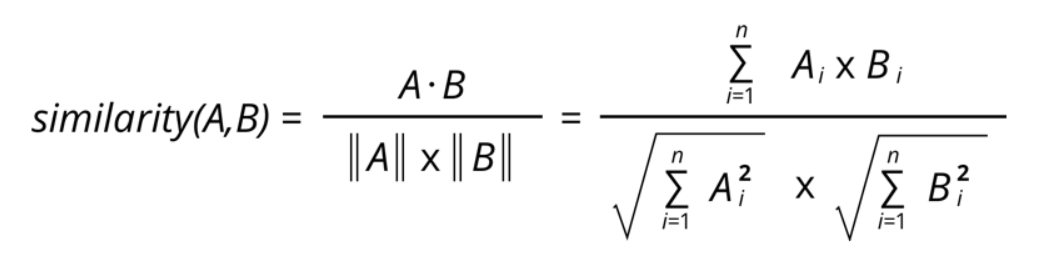

In [225]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity
cos = cosine_similarity(tfv_matrix, tfv_matrix)

### Linear Kernel

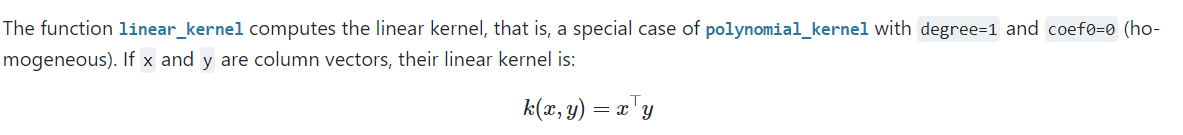

In [226]:
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity
lin = linear_kernel(tfv_matrix, tfv_matrix)

In [227]:
lin.shape

(4800, 4800)

In [228]:
sig.shape

(4800, 4800)

In [229]:
cos.shape

(4800, 4800)

In [230]:
cos_df = pd.DataFrame(cos,columns=df.index,index = df.index)

sig_df = pd.DataFrame(sig,columns=df.index,index = df.index)

lin_df = pd.DataFrame(lin,columns=df.index,index = df.index)

In [231]:
sig_df['title'] = df['original_title']
cos_df['title'] = df['original_title']
lin_df['title'] = df['original_title']

In [232]:
sig_df

id,19995,285,206647,49026,49529,559,38757,99861,767,209112,...,286939,124606,14337,67238,9367,72766,231617,126186,25975,title
id,,,,,,,,,,,,,,,,,,,,,
19995,0.761634,0.761594,0.761594,0.761595,0.761594,0.761595,0.761594,0.761596,0.761594,0.761594,...,0.761594,0.761595,0.761596,0.761594,0.761594,0.761594,0.761594,0.761594,0.761594,Avatar
285,0.761594,0.761634,0.761594,0.761594,0.761596,0.761594,0.761594,0.761595,0.761594,0.761594,...,0.761594,0.761594,0.761594,0.761594,0.761594,0.761594,0.761595,0.761594,0.761594,Pirates of the Caribbean: At World's End
206647,0.761594,0.761594,0.761634,0.761594,0.761594,0.761594,0.761595,0.761596,0.761595,0.761594,...,0.761594,0.761594,0.761594,0.761595,0.761594,0.761594,0.761595,0.761594,0.761595,Spectre
49026,0.761595,0.761594,0.761594,0.761634,0.761595,0.761595,0.761595,0.761595,0.761595,0.761600,...,0.761594,0.761595,0.761594,0.761594,0.761594,0.761595,0.761596,0.761596,0.761596,The Dark Knight Rises
49529,0.761594,0.761596,0.761594,0.761595,0.761634,0.761594,0.761595,0.761596,0.761594,0.761596,...,0.761594,0.761595,0.761594,0.761594,0.761594,0.761595,0.761595,0.761594,0.761595,John Carter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9367,0.761594,0.761594,0.761594,0.761594,0.761594,0.761594,0.761594,0.761595,0.761595,0.761594,...,0.761595,0.761594,0.761594,0.761594,0.761634,0.761594,0.761594,0.761595,0.761594,El Mariachi
72766,0.761594,0.761594,0.761594,0.761595,0.761595,0.761594,0.761595,0.761594,0.761594,0.761595,...,0.761594,0.761595,0.761594,0.761594,0.761594,0.761634,0.761594,0.761594,0.761595,Newlyweds
231617,0.761594,0.761595,0.761595,0.761596,0.761595,0.761595,0.761594,0.761594,0.761595,0.761595,...,0.761594,0.761595,0.761595,0.761594,0.761594,0.761594,0.761634,0.761595,0.761595,"Signed, Sealed, Delivered"


In [233]:
sig_df[sig_df['title'] == 'Avatar']

id,19995,285,206647,49026,49529,559,38757,99861,767,209112,...,286939,124606,14337,67238,9367,72766,231617,126186,25975,title
id,,,,,,,,,,,,,,,,,,,,,
19995,0.761634,0.761594,0.761594,0.761595,0.761594,0.761595,0.761594,0.761596,0.761594,0.761594,...,0.761594,0.761595,0.761596,0.761594,0.761594,0.761594,0.761594,0.761594,0.761594,Avatar


In [234]:
# creating the function to get the movie names from the index
def get_movie_names(dataframe,text,number=10):
    if text in list(dataframe['title']):
        new={}
        k = list(sig_df[sig_df['title'] == text].index)
        score = list(dataframe[k[0]])
        id_list = list(dataframe.columns)
        for i,j in zip(id_list,score):
            new[i]=j
        import operator
        sorted_list = sorted(new.items(), key=operator.itemgetter(1),reverse=True)
        #return(sorted_list)
        for i,j in sorted_list[1:12]:
            print (dataframe.loc[i,'title'])
    else:
        print ('Please select another movie')


In [235]:
# using sigmoid
get_movie_names(sig_df,'Spece',10)

Please select another movie


In [236]:
get_movie_names(sig_df,'Spectre',10)

Never Say Never Again
Skyfall
Thunderball
From Russia with Love
Quantum of Solace
The Man with the Golden Gun
Safe Haven
2016: Obama's America
The Living Daylights
Dr. No
The World Is Not Enough


In [237]:
# using cosine similarity
get_movie_names(cos_df,'Spectre',10)

Never Say Never Again
Skyfall
Thunderball
From Russia with Love
Quantum of Solace
The Man with the Golden Gun
Safe Haven
2016: Obama's America
The Living Daylights
Dr. No
The World Is Not Enough


In [238]:
# using linear similarity
get_movie_names(lin_df,'Spectre',10)

Never Say Never Again
Skyfall
Thunderball
From Russia with Love
Quantum of Solace
The Man with the Golden Gun
Safe Haven
2016: Obama's America
The Living Daylights
Dr. No
The World Is Not Enough


### Conclusion = As there is no difference in the recommendation using the three kernels. we can furthur the study of recommendation by incorporating cast, crew, keywords, genre in addition to the overview to improve the recommendations. Also we can now test the recommendation by deploying it over to the users and perform A/B testing.